In [9]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.morningstar import Fundamentals as Fundamentals_m
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.research import run_pipeline
from quantopian.research import prices
import alphalens as al
from alphalens.tears import create_returns_tear_sheet
from alphalens.tears import create_information_tear_sheet
from quantopian.pipeline.data import factset
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

In [6]:
def make_pipeline():
    
    growth_score = Fundamentals_m.growth_score.latest # Winner Secure
    growth_score = growth_score.winsorize(min_percentile=0.05, max_percentile=0.95)
    universe = QTradableStocksUS()
    
    combined_factor = (
        growth_score.zscore()
    )

    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe

Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.017,0.025,0.029
IC Std.,0.124,0.120,0.116
Risk-Adjusted IC,0.135,0.209,0.251
t-stat(IC),2.995,4.629,5.559
p-value(IC),0.003,0.000,0.000
IC Skew,-0.258,-0.173,-0.245
IC Kurtosis,-0.303,-0.269,-0.637


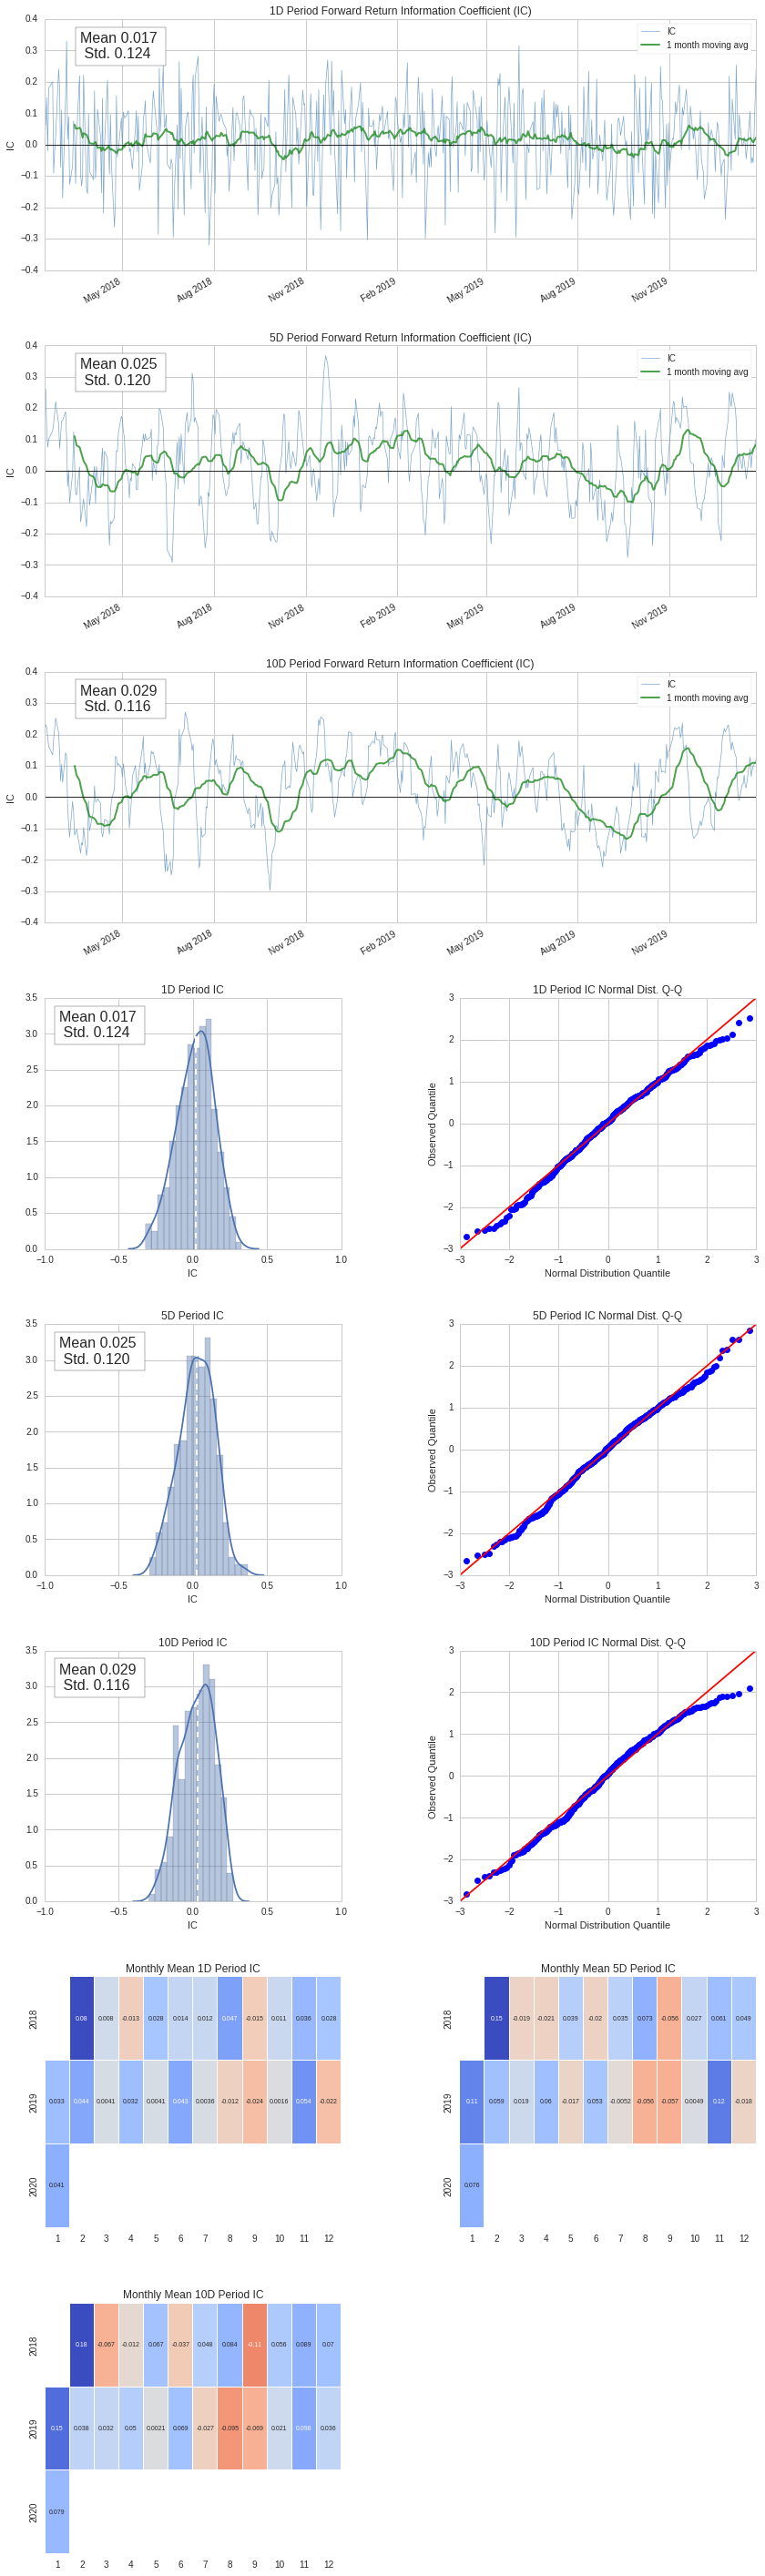

In [7]:
today = "2/11/2020"
two_years_before="2/11/2018"

pipeline_output = run_pipeline(
    make_pipeline(),
    start_date= two_years_before,
    end_date=today
)

asset_list = pipeline_output.index.levels[1].unique()
asset_prices = prices(
    asset_list,
    start=two_years_before,
    end=today
)
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['combined_factor'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)
create_information_tear_sheet(factor_data)

Returns Analysis


,1D,5D,10D
Ann. alpha,0.041,0.038,0.037
beta,0.100,0.063,0.045
Mean Period Wise Return Top Quantile (bps),1.675,1.433,1.363
Mean Period Wise Return Bottom Quantile (bps),-1.674,-1.432,-1.363
Mean Period Wise Spread (bps),3.349,2.865,2.726


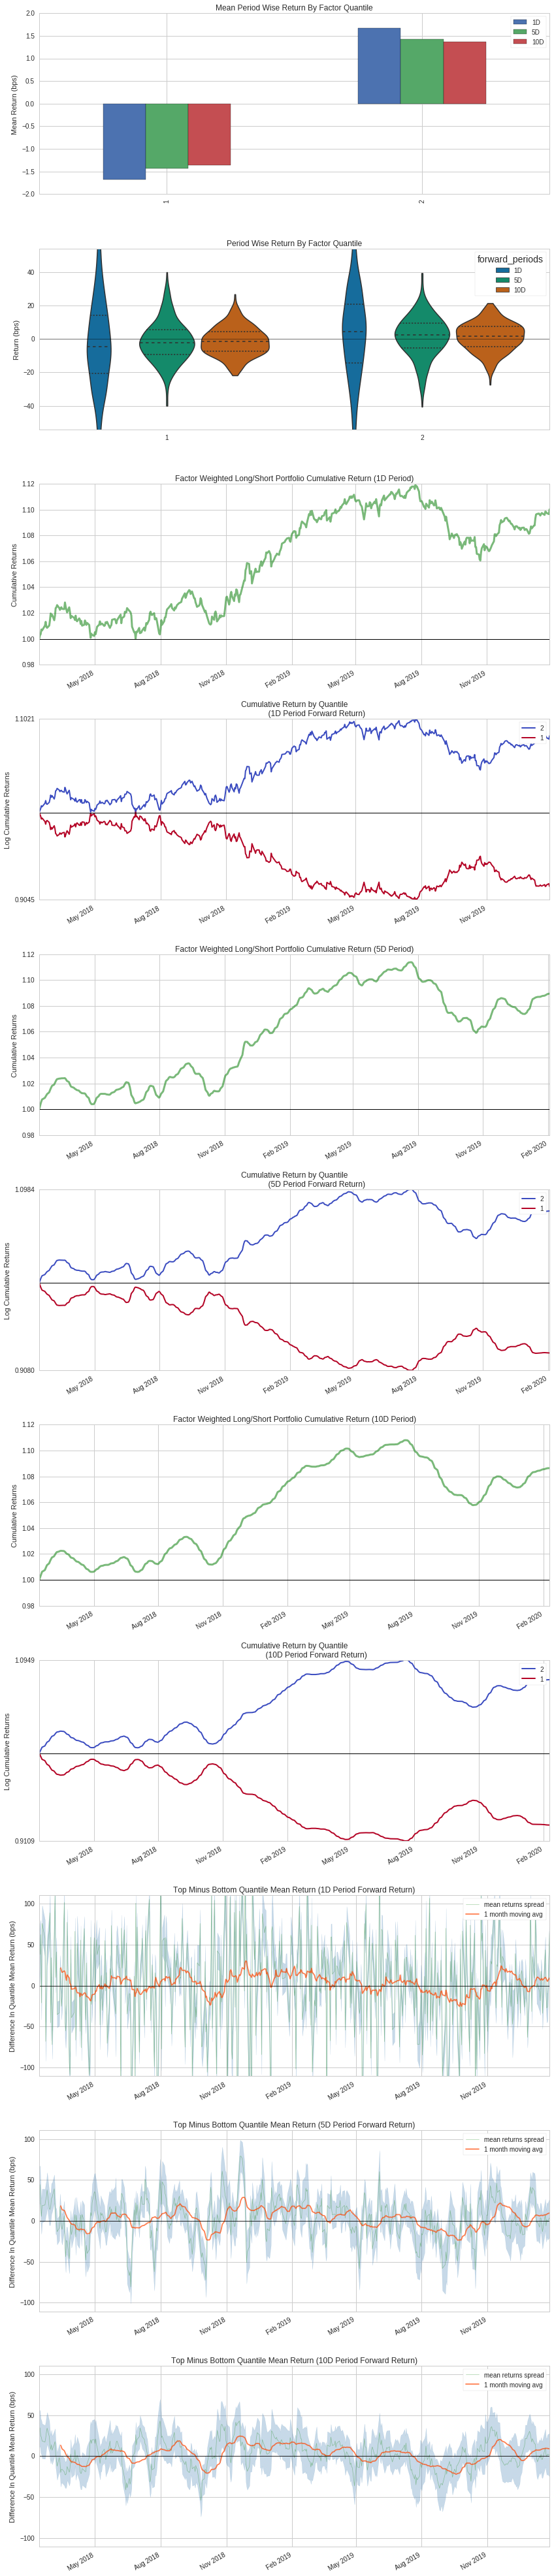

In [10]:
create_returns_tear_sheet(factor_data)